## Customer Segmentation / Clustering

### Problem Statement

To perform customer segmentation using clustering techniques. An dto use both profile information and transction information.

#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading datasets

In [2]:
customers = pd.read_csv('./customers.csv')
products = pd.read_csv('./products.csv')
transactions = pd.read_csv('./transaction.csv')

In [3]:
# Converting dates to datetime format for consistency
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"], format="%d-%m-%Y", errors="coerce")
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"], format="%d-%m-%Y %H:%M", errors="coerce")

In [4]:
# Merging datasets to create a complete view
transactions_products = pd.merge(transactions, products, on="ProductID", how="left")
full_data = pd.merge(transactions_products, customers, on="CustomerID", how="left")

#### Feature Engineering

In [5]:
customer_spending = full_data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    num_transactions=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean")
).reset_index()

In [6]:
category_preferences = pd.crosstab(full_data["CustomerID"], full_data["Category"], normalize="index")

In [7]:
# Merging spending and category preferences
customer_features = pd.merge(customer_spending, category_preferences, on="CustomerID", how="left")

In [8]:
# Normalizing features
scaler = MinMaxScaler()
clustering_data = customer_features.drop("CustomerID", axis=1)
clustering_data_normalized = scaler.fit_transform(clustering_data)

In [9]:
# Determining number of clusters
k_values = range(2, 11)
inertia = []
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_data_normalized)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(clustering_data_normalized, kmeans.labels_))

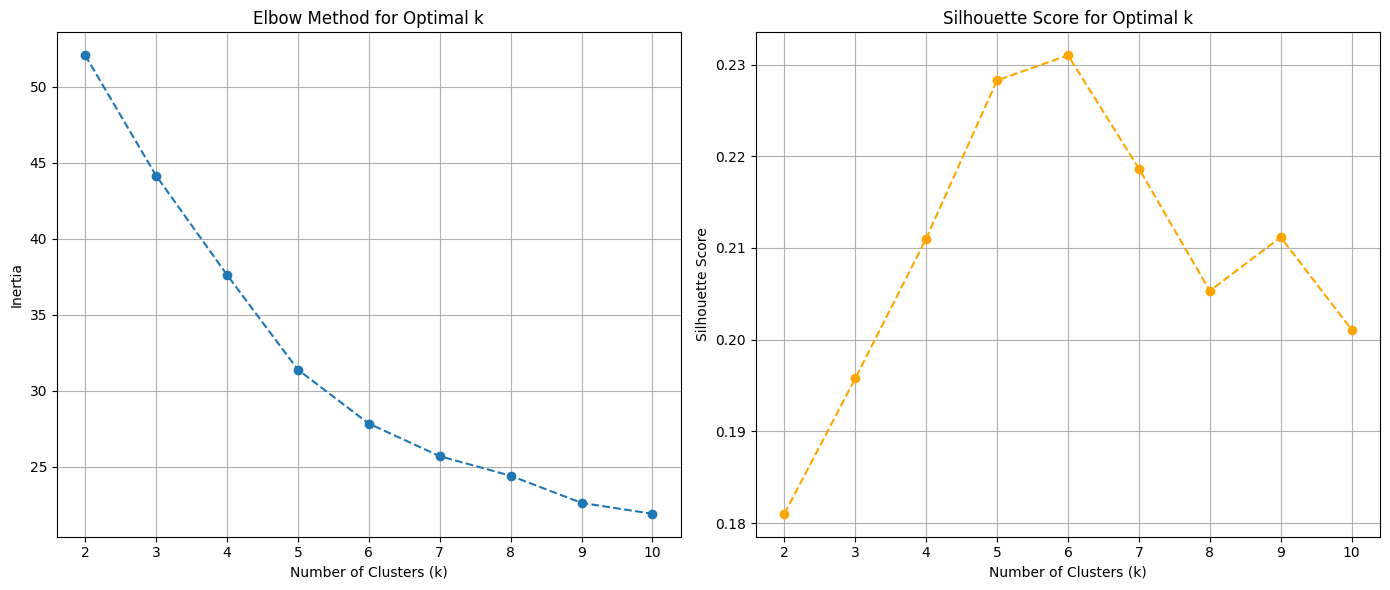

In [10]:
# Plotting Elbow Method and Silhouette Scores
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='orange')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.tight_layout()
plt.show()

In [11]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(clustering_data_normalized)
db_index = davies_bouldin_score(clustering_data_normalized, kmeans_labels)

#### DB Index

The Davies-Bouldin Index (DBI) is a metric used to evaluate the quality of clustering. It measures the average similarity between each cluster and its most similar cluster, with lower values indicating better clustering. DBI considers both the intra-cluster dispersion (compactness) and inter-cluster separation. It is ideal for comparing different clustering models, where the goal is to minimize the index.

In [12]:
# Computing Davies-Bouldin Index
db_index = davies_bouldin_score(clustering_data_normalized, kmeans_labels)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.3836632381937861


#### Visualizing clusters using PCA

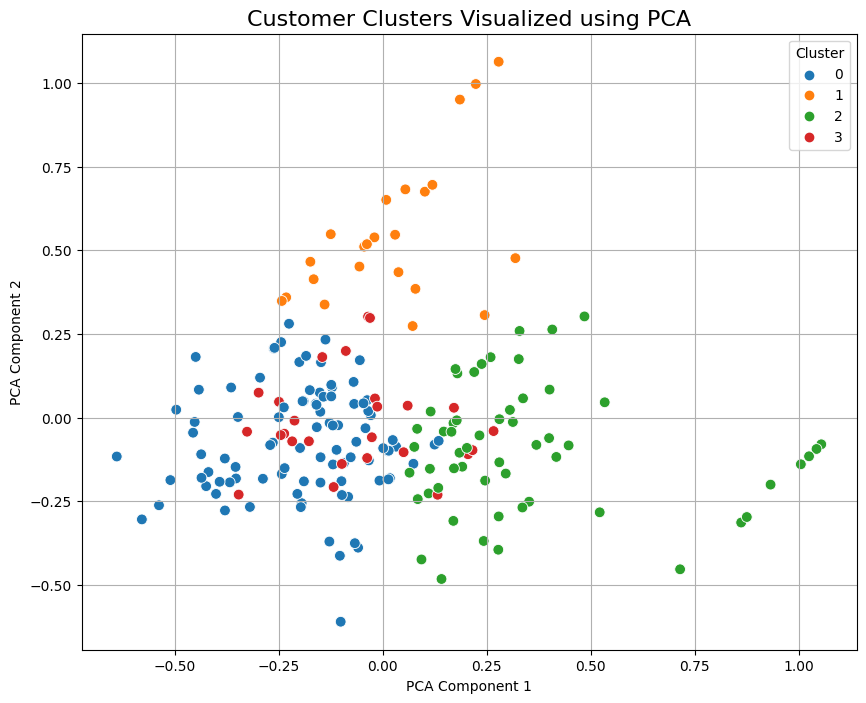

In [13]:
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(clustering_data_normalized)
clustered_data = pd.DataFrame(pca_data, columns=["PCA1", "PCA2"])
clustered_data["Cluster"] = kmeans_labels
plt.figure(figsize=(10, 8))
sns.scatterplot(data=clustered_data, x="PCA1", y="PCA2", hue="Cluster", palette="tab10", s=60)
plt.title("Customer Clusters Visualized using PCA", fontsize=16)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", fontsize=10, loc="upper right")
plt.grid()
plt.show()